In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

## Acquire

In [2]:
df = pd.read_csv('GlobalLandTemperaturesByState.csv')  

In [3]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil


## Prepare 

In [4]:
df = df[df.State.str.contains("Texas")]

In [5]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
549727,1820-01-01,4.489,3.369,Texas,United States
549728,1820-02-01,9.081,2.873,Texas,United States
549729,1820-03-01,12.657,2.423,Texas,United States
549730,1820-04-01,19.215,2.501,Texas,United States
549731,1820-05-01,22.577,2.495,Texas,United States


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 549727 to 552051
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dt                             2325 non-null   object 
 1   AverageTemperature             2325 non-null   float64
 2   AverageTemperatureUncertainty  2325 non-null   float64
 3   State                          2325 non-null   object 
 4   Country                        2325 non-null   object 
dtypes: float64(2), object(3)
memory usage: 109.0+ KB


In [8]:
df.dt = pd.to_datetime(df.dt)

In [9]:
df = df.set_index('dt').sort_index()

In [10]:
df.head()

,AverageTemperature,AverageTemperatureUncertainty,State,Country
dt,,,,
1820-01-01,4.489,3.369,Texas,United States
1820-02-01,9.081,2.873,Texas,United States
1820-03-01,12.657,2.423,Texas,United States
1820-04-01,19.215,2.501,Texas,United States
1820-05-01,22.577,2.495,Texas,United States


In [11]:
#Drop country 
df = df.drop(["Country"],axis=1)

In [25]:
#Drop state 
df = df.drop(["State"],axis=1)

In [26]:
df.head()

,AverageTemperature,AverageTemperatureUncertainty
dt,,
1820-01-01,4.489,3.369
1820-02-01,9.081,2.873
1820-03-01,12.657,2.423
1820-04-01,19.215,2.501
1820-05-01,22.577,2.495


In [28]:
#summary statistics for numeric columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AverageTemperature,2325.0,18.107234,7.413791,1.965,11.206,18.378,25.398,31.401
AverageTemperatureUncertainty,2325.0,0.794785,0.893291,0.044,0.180,0.310,1.241,4.950


array([[<AxesSubplot:title={'center':'AverageTemperature'}>,
        <AxesSubplot:title={'center':'AverageTemperatureUncertainty'}>]],
      dtype=object)

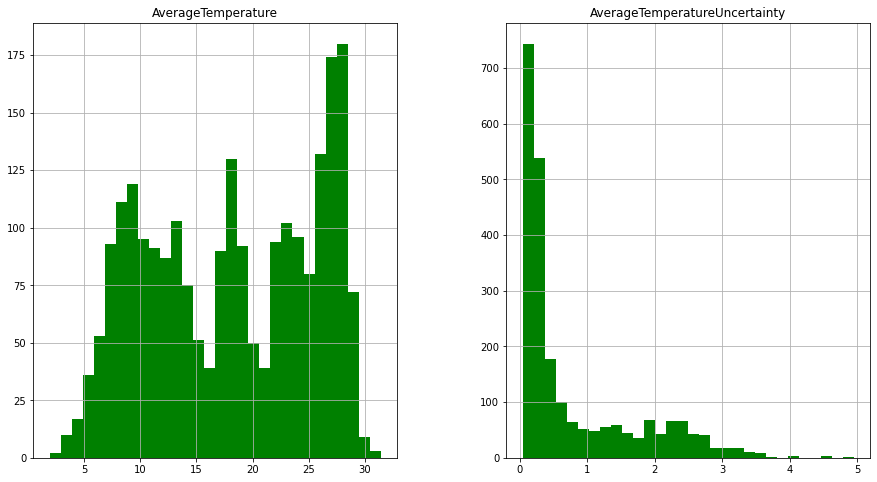

In [29]:
#initial plots
df.hist(bins=30,figsize=(15,8),color='green')

### Split data

In [14]:
# set train size to be 50% of total 
train_size = int(len(df) * .5)
train_size

1162

In [15]:
# set validate size to be 30% of total 
validate_size = int(len(df) * .3)
validate_size

697

In [16]:
# set test size to be number of rows remaining. 
test_size = int(len(df) - train_size - validate_size)
test_size

466

In [17]:
# validate will go from 697 to 697+1162
validate_end_index = train_size + validate_size
validate_end_index

1859

In [18]:
# train will go from 0 to 1161
train = df[: train_size]
# validate will go from 1162 to 1858
validate = df[train_size:validate_end_index]
# test will include 1859 to the end
test = df[validate_end_index:]

In [19]:
#Verify Splits
# is len of train + validate + test == lenght of entire dataframe. 
print(len(train) + len(validate) + len(test) == len(df))

True


In [20]:
print(df.head(1) == train.head(1))


            AverageTemperature  AverageTemperatureUncertainty  State
dt                                                                  
1820-01-01                True                           True   True


In [22]:
#Let's plot our data first, viewing where the data is split into train and test.
train.columns

Index(['AverageTemperature', 'AverageTemperatureUncertainty', 'State'], dtype='object')

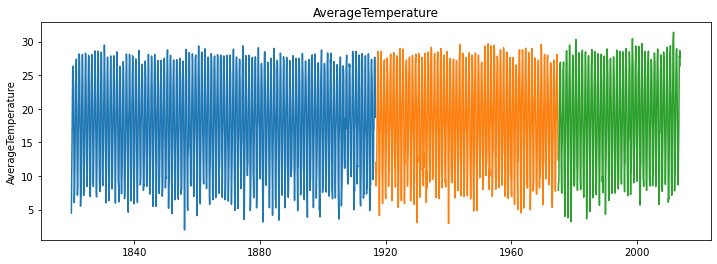

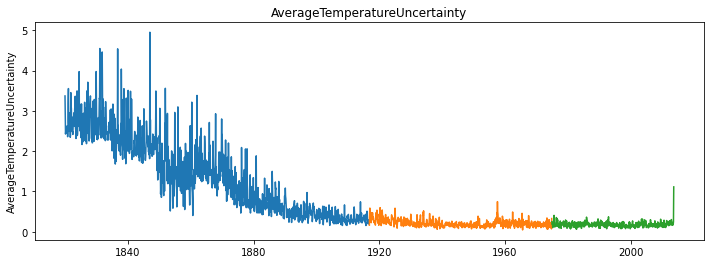

In [24]:
for col in train.columns:
    if col != 'State':
        plt.figure(figsize=(12,4))
        plt.plot(train[col])
        plt.plot(validate[col])
        plt.plot(test[col])
        plt.ylabel(col)
        plt.title(col)
        plt.show()

## Explore

In [30]:
#add month and year column
train['month'] = train.index.month
train['year'] = train.index.year

train.head()

,AverageTemperature,AverageTemperatureUncertainty,State,month,year
dt,,,,,
1820-01-01,4.489,3.369,Texas,1,1820
1820-02-01,9.081,2.873,Texas,2,1820
1820-03-01,12.657,2.423,Texas,3,1820
1820-04-01,19.215,2.501,Texas,4,1820
1820-05-01,22.577,2.495,Texas,5,1820


In [32]:
#set target y variables
y = train.AverageTemperature
y_unc = train.AverageTemperatureUncertainty

y.head(), y_unc.head()

(dt
 1820-01-01     4.489
 1820-02-01     9.081
 1820-03-01    12.657
 1820-04-01    19.215
 1820-05-01    22.577
 Name: AverageTemperature, dtype: float64,
 dt
 1820-01-01    3.369
 1820-02-01    2.873
 1820-03-01    2.423
 1820-04-01    2.501
 1820-05-01    2.495
 Name: AverageTemperatureUncertainty, dtype: float64)

### Does the data increase, decrease, or stay the same over time?

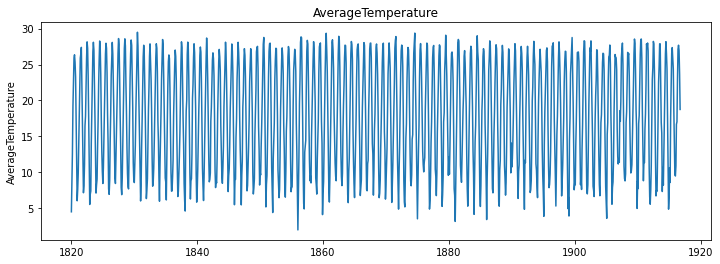

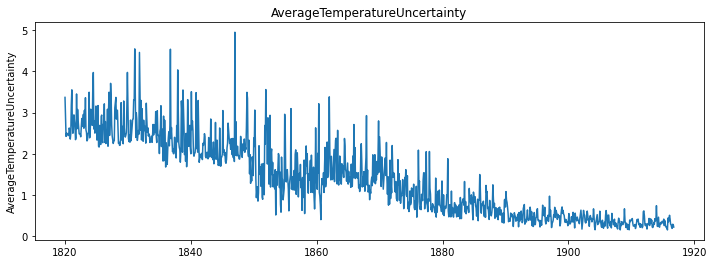

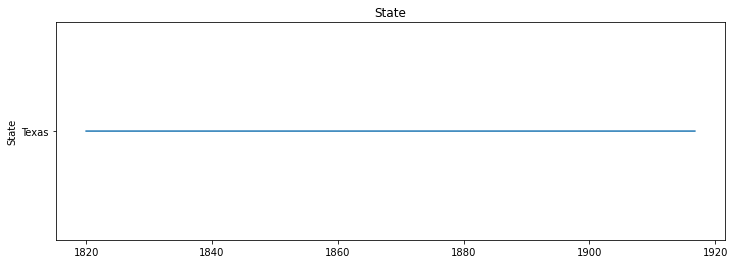

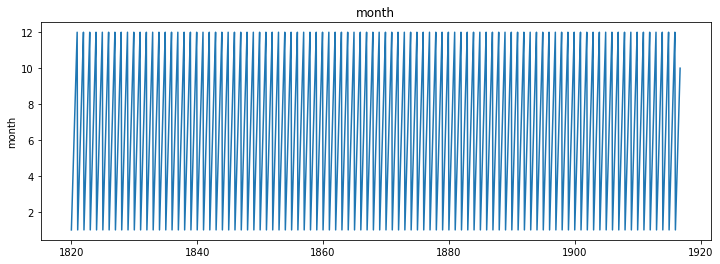

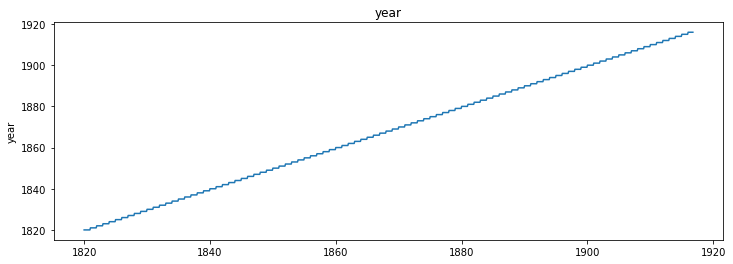

In [33]:
#loop to visualize avg temp/avg temp uncertainty over time
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

### What is the distribution of yearly average temperature and yearly average uncertainty?

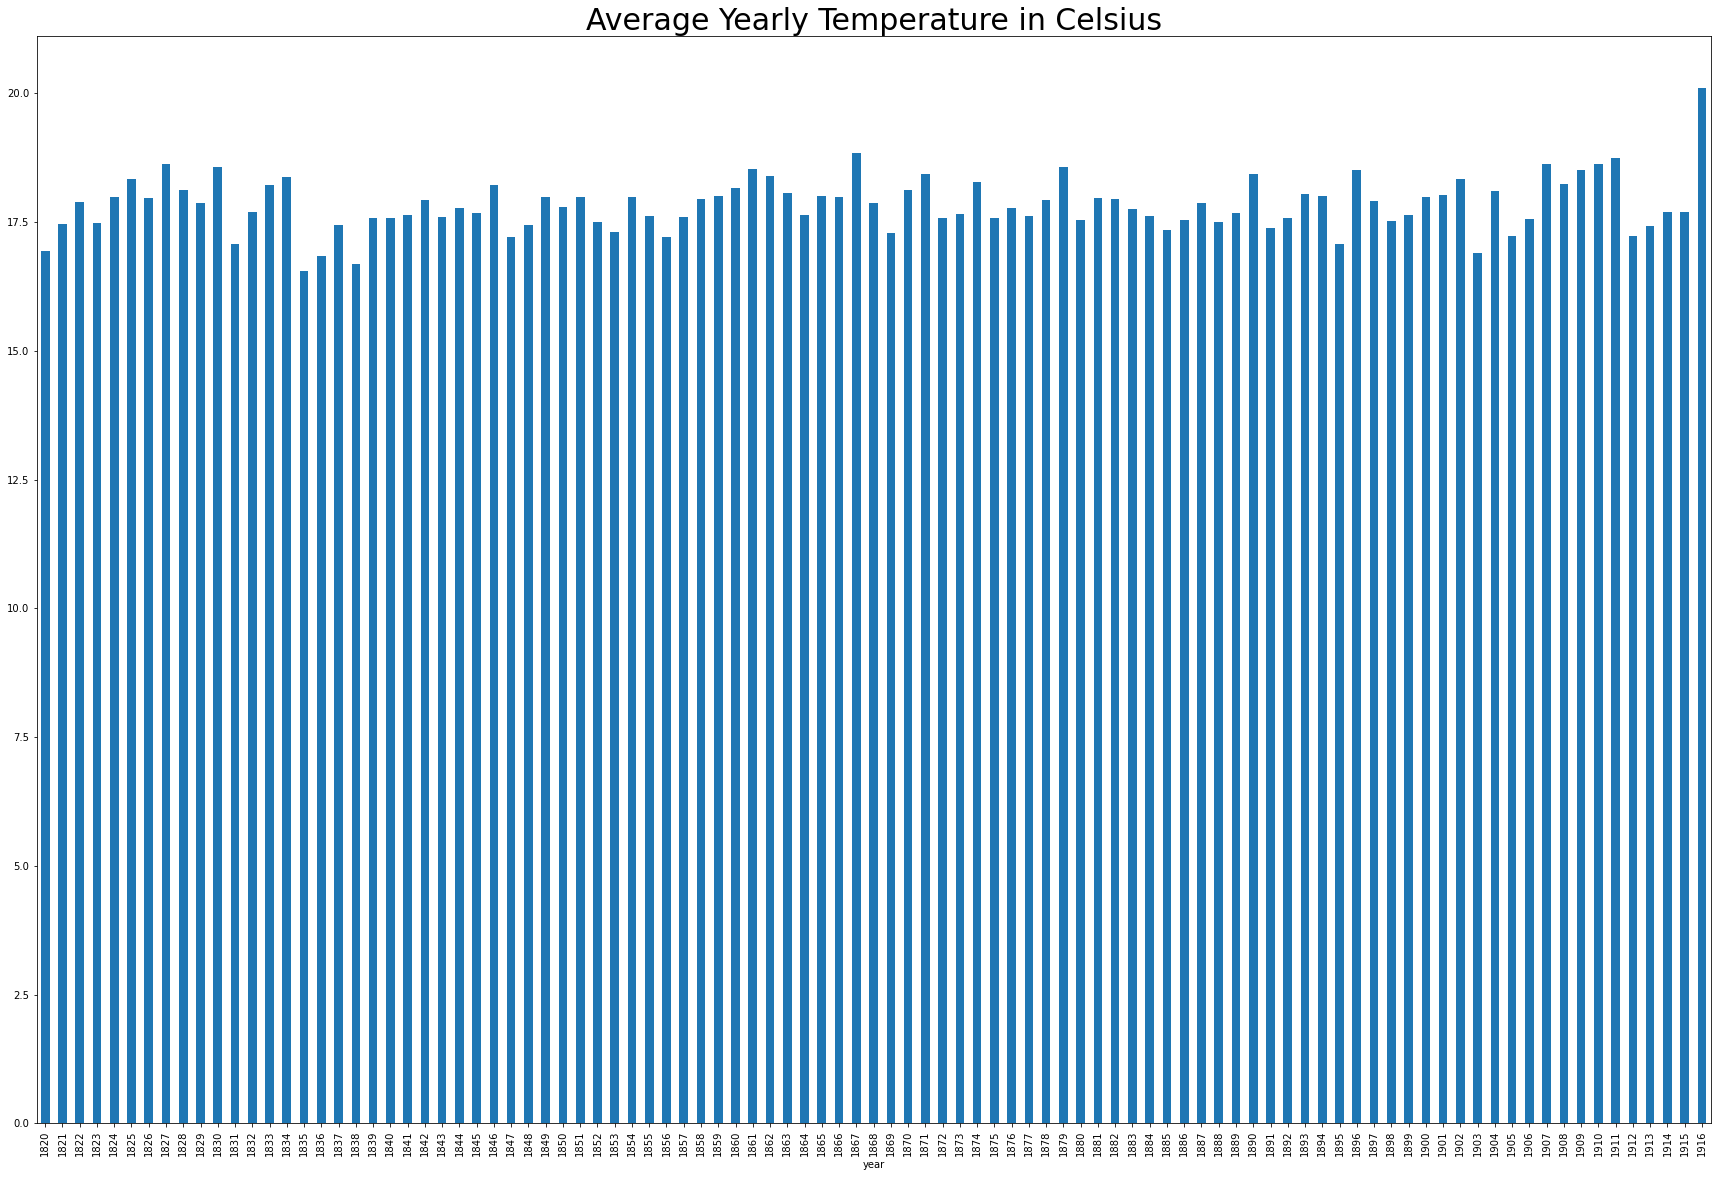

In [35]:
#yearly average temperature
train.groupby('year').AverageTemperature.mean().plot.bar(figsize=(30,20))
plt.title('Average Yearly Temperature in Celsius', fontsize=30)
plt.show()

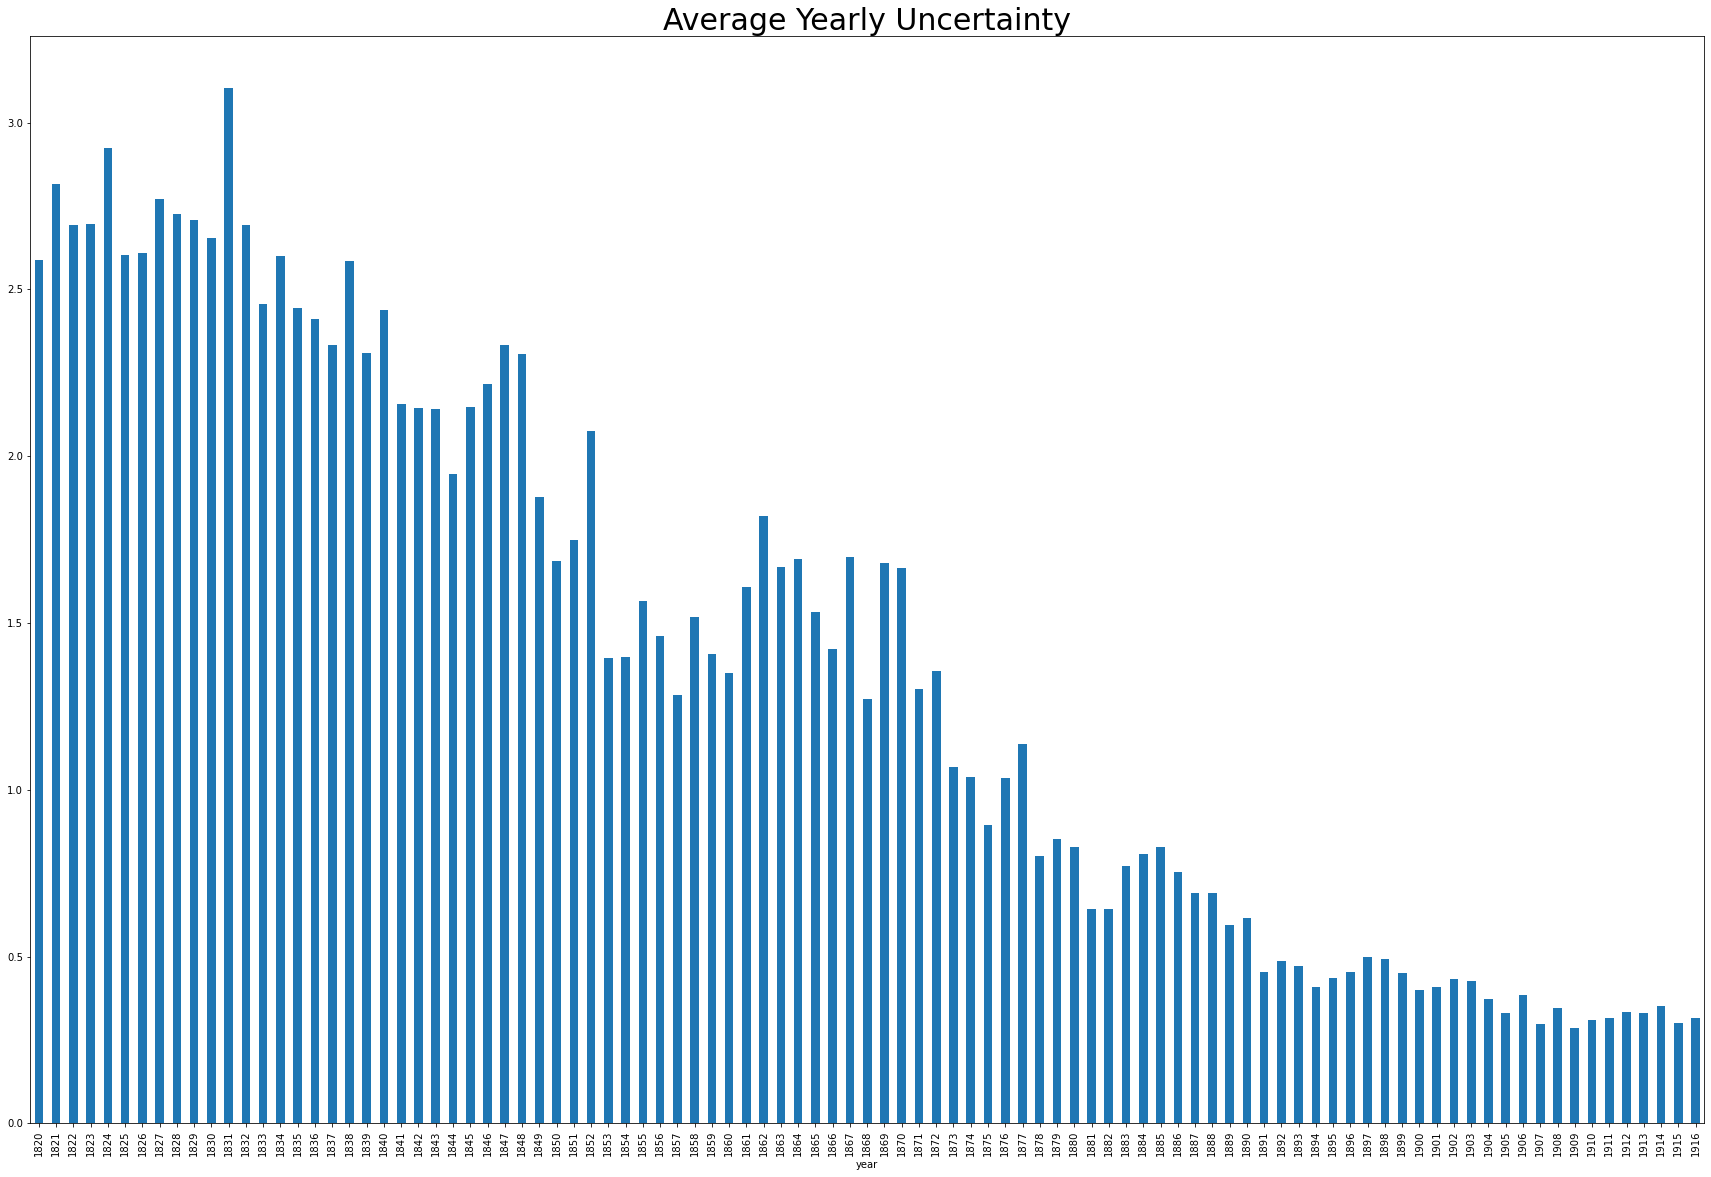

In [36]:
#yearly average uncertainty
train.groupby('year').AverageTemperatureUncertainty.mean().plot.bar(figsize=(30,20))
plt.title('Average Yearly Uncertainty', fontsize=30)
plt.show()

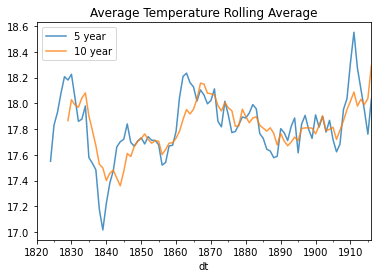

In [37]:
#reducing noise by resampling avg_temp data and rolling averages
y.resample('Y').mean().rolling(5).mean().plot(alpha=.8, label='5 year')
y.resample('Y').mean().rolling(10).mean().plot(alpha=.8, label='10 year')
plt.legend()
plt.title('Average Temperature Rolling Average')
plt.show()

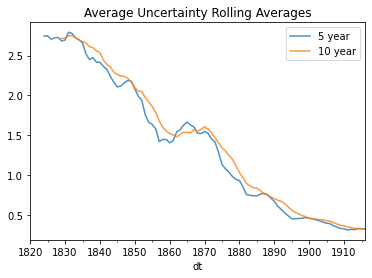

In [38]:
#reducing noise by resampling avg_uncertainty and rolling averages
y_unc.resample('Y').mean().rolling(5).mean().plot(alpha=.8, label='5 year')
y_unc.resample('Y').mean().rolling(10).mean().plot(alpha=.8, label='10 year')
plt.legend()
plt.title('Average Uncertainty Rolling Averages')
plt.show()

### What is the distribution of monthly average temperature and monthly average uncertainty?


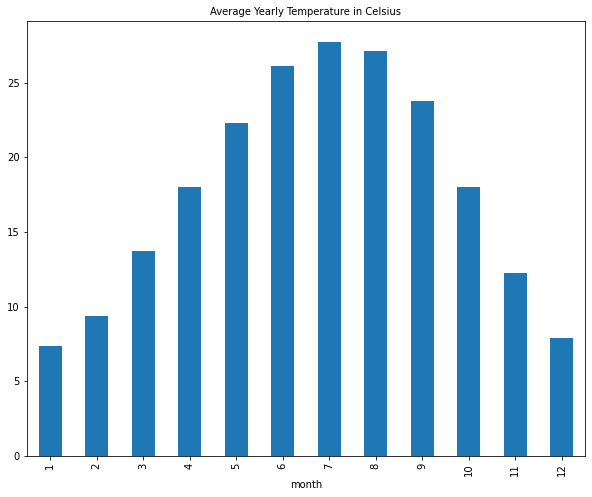

In [39]:
#monthly average temperature
train.groupby('month').AverageTemperature.mean().plot.bar(figsize=(10,8))
plt.title('Average Yearly Temperature in Celsius', fontsize=10)
plt.show()

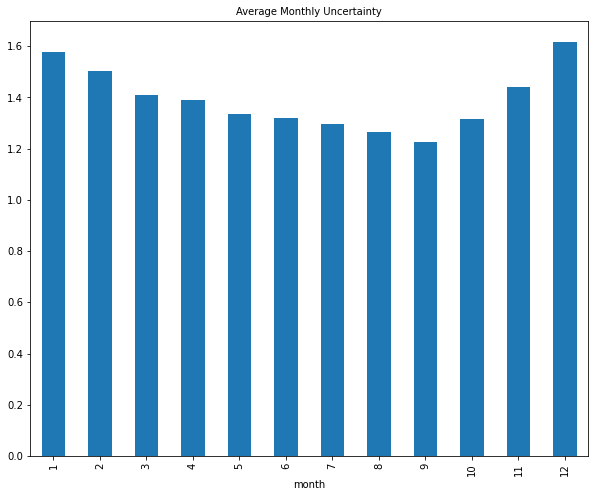

In [40]:
#monthly average uncertainty
train.groupby('month').AverageTemperatureUncertainty.mean().plot.bar(figsize=(10,8))
plt.title('Average Monthly Uncertainty', fontsize=10)
plt.show()